## Rollout Bayesian Optimization

In [19]:
using LinearAlgebra
using Plots
using Random

In [101]:
include("../rollout.jl")
include("../testfns.jl")

TestLinearCosine1D (generic function with 3 methods)

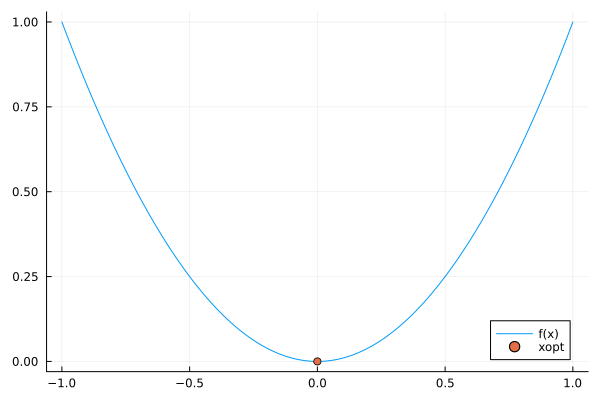

In [102]:
testfn = TestQuadratic1D()
tplot(testfn)

### Dense Experiments in 1D for Rollout Acquisition Functions
We'll do a comparative analysis, visually, of the structure of the rollout acquisition function in 1D for horizons 0 and 1.

In [103]:
function sample_random_matrix(xmin, xmax, d, n)
    matrix = zeros(d, n)
    for i in 1:d
        for j in 1:n
            matrix[i, j] = xmin + (xmax - xmin) * rand()
        end
    end
    return matrix
end

sample_random_matrix (generic function with 1 method)

In [104]:
HORIZON = 0
MC_SAMPLES = 50
# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON+1);
rns = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1);

lbs = testfn.bounds[:, 1]
ubs = testfn.bounds[:, 2]
σn2 = 1e-6
θ = [1.]

ϵ, num_starts = 1e-6, 64
s = SobolSeq(lbs, ubs)

xstarts = reduce(hcat, next!(s) for i = 1:num_starts)
xstarts = hcat(xstarts, lbs .+ ϵ)
xstarts = hcat(xstarts, ubs .- ϵ);

ψ = kernel_matern52(θ)
Random.seed!(1906)
# X = sample_random_matrix(minimum(lbs), minimum(ubs), testfn.dim, 2)
X = [-.9;; -.89;; .89;; .9;;]
y = [testfn.f(X[:,j]) for j in 1:size(X, 2)]
sur = fit_surrogate(ψ, X, y; σn2=σn2);
sur = optimize_hypers_optim(sur, kernel_matern52)
# Probably makes sense to build this sequence internally and we can get rid of the
# assertion for making sure we received the correct sequence

RBFsurrogate(RBFfun([0.8625828222087445], var"#ψ#3858"{var"#k#3868", Vector{Float64}}(var"#k#3868"(), [0.8625828222087445]), var"#Dρ_ψ#3859"{var"#ψ#3858"{var"#k#3868", Vector{Float64}}}(var"#ψ#3858"{var"#k#3868", Vector{Float64}}(var"#k#3868"(), [0.8625828222087445])), var"#Dρρ_ψ#3860"{var"#Dρ_ψ#3859"{var"#ψ#3858"{var"#k#3868", Vector{Float64}}}}(var"#Dρ_ψ#3859"{var"#ψ#3858"{var"#k#3868", Vector{Float64}}}(var"#ψ#3858"{var"#k#3868", Vector{Float64}}(var"#k#3868"(), [0.8625828222087445]))), var"#∇θ_ψ#3861"{var"#k#3868", Vector{Float64}}(var"#k#3868"(), [0.8625828222087445])), [-0.9 -0.89 0.89 0.9], [1.000001 0.999888018784591 0.12376087998785473 0.12159436263549446; 0.999888018784591 1.000001 0.1259617684038213 0.12376087998785473; 0.12376087998785473 0.1259617684038213 1.000001 0.999888018784591; 0.12159436263549446 0.12376087998785473 0.999888018784591 1.000001], [1.000000499999875 0.0 0.0 0.0; 0.9998875188409565 0.015031622203734656 0.0 0.0; 0.12376081810746115 0.14734744038968547 0.

In [105]:
domain = range(lbs[1], ubs[1], length=100)
domain = filter(x -> !(x in sur.X), domain)
ex = zeros(length(domain))
dex = zeros(length(domain))
stderrex = zeros(length(domain))

candidate_locations = SharedMatrix{Float64}(testfn.dim, num_starts)
candidate_values = SharedArray{Float64}(num_starts)

for (i, x) in enumerate(domain)
    print("|")
    tp = TrajectoryParameters(
        x0=[x], h=HORIZON, mc_iters=MC_SAMPLES, rnstream_sequence=rns, lbs=lbs, ubs=ubs
    )
    μ, ∇μ, stderr_μ, stderr_∇μ = simulate_trajectory(
        sur, tp, xstarts,
        candidate_locations=candidate_locations, candidate_values=candidate_values,
        variance_reduction=false
    )
    dex[i] = first(∇μ)
    stderrex[i] = stderr_μ
    ex[i] = μ
end


||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

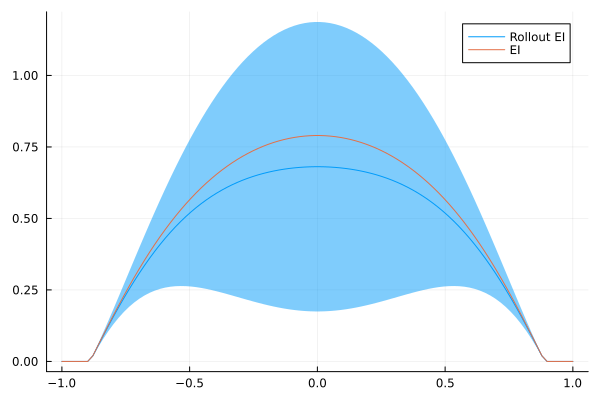

In [106]:
plot(domain, ex, label="Rollout EI", ribbons=stderrex)
plot!(domain, [sur([x]).EI for x in domain], label="EI")

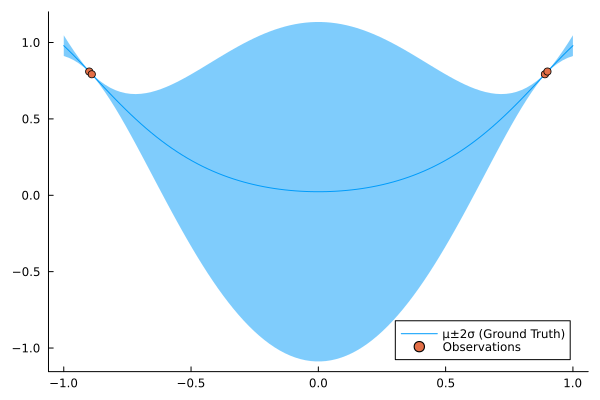

In [107]:
plot1D(sur; xmin=-1., xmax=1.)

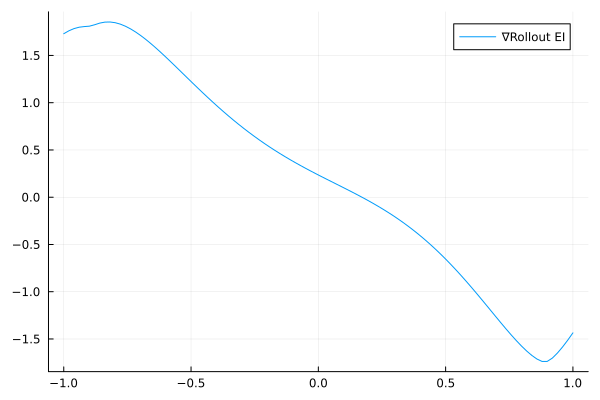

In [108]:
plot(domain, dex, label="∇Rollout EI")
# plot!(domain, [sur([x]).∇EI[1] for x in domain], label="∇EI")

In [112]:
sum(I(5), dims=1)

1×5 Matrix{Int64}:
 1  1  1  1  1

In [113]:
M = [2 3 4;
     4 6 10;]

2×3 Matrix{Int64}:
 2  3   4
 4  6  10

In [117]:
sum(M, dims=2) / 3

2×1 Matrix{Float64}:
 3.0
 6.666666666666667